In [ ]:
#Boxplot of distributions
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
dir = Path.home() / 'Documents' / 'DTU' / 'E23' / '02456_Deep_Learning' / 'Brain_Project' / 'BRaTS_UNET'
distributions = np.load(dir / 'class_distributions.npy')
avg_distributions = distributions/np.sum(distributions, axis=1)[:,None]
#Plot histrogram for every patient on top of each other
plt.subplot(1,2,1)
#Histogram
#plt.hist(np.sum(distributions,axis=0), bins=100)
sns.boxplot(data=avg_distributions, linewidth=1.5, width=0.5, fliersize=1.5, whis=1.5, saturation=1)
plt.title('Class distributions')
plt.xlabel('Class')
plt.ylabel('Percentage of pixels')

plt.subplot(1,2,2)
#plot last 3 classes
#Add 1 to each class idx to get class 1-3
sns.boxplot(data=avg_distributions[:,1:], linewidth=1.5, width=0.5, fliersize=1.5, whis=1.5, saturation=1)
#set ticks
plt.xticks(np.arange(3), ('1', '2', '3'))
plt.title('Class distributions for classes 1-3')
plt.xlabel('Class')
plt.ylabel('Percentage of pixels')
plt.tight_layout()


In [ ]:
import nibabel as nib
from pathlib import Path
import torch
extensions = ['flair.nii.gz', 't1.nii.gz', 't1ce.nii.gz', 't2.nii.gz', 'seg.nii.gz']
patient_id = 'BraTS2021_00495'
patient_dir = Path(str('/Users/christianvalentinkjaer/Documents/DTU/E23/02456_Deep_Learning/Brain_Project/BRaTS_UNET/data/archive/BraTS2021_00495'))
data = [nib.load(str(patient_dir / f'{patient_id}_{ext}')).get_fdata() for ext in extensions]

In [ ]:
#Create np array and tensor of randint
np_array = np.random.randint(0, 4, size=(240, 240, 155))
tensor = torch.randint(0, 4, size=(240, 240, 155))


In [ ]:
np_array-tensor.numpy()

In [ ]:
import nibabel as nib
import numpy as np
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from skimage.util import montage
from PIL import Image

from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#from torchmetrics import JaccardIndex, ConfusionMatrix, Dice


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, dropout = 0.0):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, dropout = 0.0):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels, dropout=dropout)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, trilinear=True, dropout = 0.0):
        super().__init__()

        # if trilinear, use the normal convolutions to reduce the number of channels
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, dropout=dropout)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[4] - x1.size()[4]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2,x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, n_channels, n_classes, trilinear=False, scale_channels=1):
        super(UNet3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.trilinear = trilinear

        self.inc = (DoubleConv(n_channels, 32//scale_channels, dropout=0.1))
        self.down1 = (Down(32//scale_channels, 64//scale_channels, dropout=0.1))
        self.down2 = (Down(64//scale_channels, 128//scale_channels, dropout=0.2))
        self.down3 = (Down(128//scale_channels, 256//scale_channels, dropout=0.3))
        factor = 2 if trilinear else 1
        self.up1 = (Up(256//scale_channels, (128//scale_channels) // factor, trilinear, dropout=0.1))
        self.up2 = (Up(128//scale_channels, (64//scale_channels) // factor, trilinear, dropout=0.2))
        self.up3 = (Up(64//scale_channels, (32//scale_channels) // factor, trilinear, dropout=0.3))
        self.outc = (OutConv(32//scale_channels, n_classes))
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

class BrainDataset(Dataset):
    def __init__(self, patient_ids: list, data_dir: Path, binary='WT'): #(WT, TC, MT)
        self.patient_ids = patient_ids
        self.data_dir = data_dir
        self.binary = binary
        self.extensions = ['flair.nii.gz', 't1ce.nii.gz', 't2.nii.gz','seg.nii.gz']

    def load_nifti_file(self, file_path):
        return nib.load(file_path).get_fdata()

    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        data_paths = [self.data_dir / patient_id / f'{patient_id}_{data_id}' for data_id in self.extensions]
        data = [self.load_nifti_file(path) for path in data_paths]
        target = torch.from_numpy(np.where(data[-1]==4, 3, data[-1])).long()
        if self.binary == 'WT':
            target = torch.where(target==0, 0, 1)
        elif self.binary == 'MT':
            target = torch.where(target==3, 1, target)
            target = torch.where(target==2, 0, target)
        elif self.binary == 'TC':
            target = torch.where(target==1, 1, 0)
        else:
            raise ValueError('binary must be one of: WT, MT, TC')
        data = torch.cat([torch.from_numpy(data[i]).unsqueeze(0) for i in range(len(self.extensions)-1)], dim=0)

        start_idx = 56
        end_idx = 184
        start_idx_height = 13
        end_idx_height = 141
        
        data = data[:,start_idx:end_idx,start_idx:end_idx,start_idx_height:end_idx_height]
        target = target[start_idx:end_idx,start_idx:end_idx,start_idx_height:end_idx_height]

        #normalize data in each channel min max normalization
        for i in range(data.shape[0]):
            data[i] = (data[i] - data[i].min()) / (data[i].max() - data[i].min())

        return data, target, patient_id
    
def predictions_plot(image, mask_true, mask_pred, patient_id='BraTS2021_00495'):
    #Args:
    #mask_true: true binary mask is a tensor of size (1, 2, 128,128,128)
    #mask_pred: predicted binary mask is a tensor of size (1, 2, 128,128,128)
    #image: is a flair data tensor of size (128,128,128)
    #patient_id: is a string of the patient id
    assert len(mask_true.shape) == 5
    assert len(mask_pred.shape) == 5
    assert len(image.shape) == 3

    img_tensor = image.cpu().detach().numpy()
    mask_true_tensor = mask_true.squeeze()[1].squeeze().cpu().detach().numpy()
    mask_pred_tensor = mask_pred.squeeze()[1].squeeze().cpu().detach().numpy()

    #Pad zeros to size 160x160x160
    img_tensor = np.pad(img_tensor, ((16,16),(16,16),(16,16)), 'constant', constant_values=0)
    mask_true_tensor = np.pad(mask_true_tensor, ((16,16),(16,16),(16,16)), 'constant', constant_values=0)
    mask_pred_tensor = np.pad(mask_pred_tensor, ((16,16),(16,16),(16,16)), 'constant', constant_values=0)
    

    image = np.rot90(montage(img_tensor))
    mask_true = np.rot90(montage(mask_true_tensor))
    mask_pred = np.rot90(montage(mask_pred_tensor))


    intersection = np.logical_and(mask_true, mask_pred)
    fig, ax = plt.subplots(1, 1, figsize = (8, 8))
    plt.subplot(1,1,1)
    ax.imshow(image, cmap ='bone')
    ax.imshow(np.ma.masked_where(mask_true == False, mask_true),
                cmap='cool', alpha=0.9)
    ax.imshow(np.ma.masked_where(mask_pred == False, mask_pred),
                cmap='spring', alpha=0.6)
    ax.imshow(np.ma.masked_where(intersection == False, intersection),
                cmap='winter', alpha=1)
    plt.suptitle(f'Error plot patient: {patient_id}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(handles=[Line2D([0], [0], color='pink', lw=4, label='True'),
                       Line2D([0], [0], color='yellow', lw=4, label='Predicted'),
                       Line2D([0], [0], color='blue', lw=4, label='Intersection')], loc = 'lower center', bbox_to_anchor=(0.5, -0.125), frameon=False)
    plt.box(False)
    ax.axis('off')
    return fig
#MAIN
# 1. Load data
data_dir = Path(str('/Users/christianvalentinkjaer/Documents/DTU/E23/02456_Deep_Learning/Brain_Project/BRaTS_UNET/data/archive'))
val_ids = ['BraTS2021_00495']
start_idx, end_idx, start_idx_height, end_idx_height = 56, 184, 13, 141
true_masks = [nib.load(data_dir / 'BraTS2021_00495' / f'{patient}_seg.nii.gz').get_fdata() for patient in val_ids]
true_masks = [torch.from_numpy(np.where(mask==4, 3, mask)).long() for mask in true_masks]
true_masks = [mask[start_idx:end_idx,start_idx:end_idx,start_idx_height:end_idx_height] for mask in true_masks]

# 2. Create dataset for validation
val_set_WT = BrainDataset(patient_ids=val_ids, data_dir=data_dir, binary='WT')
val_set_TC = BrainDataset(patient_ids=val_ids, data_dir=data_dir, binary='TC')
val_set_MT = BrainDataset(patient_ids=val_ids, data_dir=data_dir, binary='MT')

models_path = Path(str('/Users/christianvalentinkjaer/Documents/DTU/E23/02456_Deep_Learning/Brain_Project/BRaTS_UNET/models'))

# 3 Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_TC = UNet3D(n_channels=3, n_classes=2, trilinear=False, scale_channels=1)
model_WT = UNet3D(n_channels=3, n_classes=2, trilinear=False, scale_channels=1)
model_MT = UNet3D(n_channels=3, n_classes=2, trilinear=False, scale_channels=1)

model_TC.load_state_dict(torch.load(models_path / 'model_TC_baseline.pt', map_location='cpu'))
model_WT.load_state_dict(torch.load(models_path / 'model_WT_baseline.pt', map_location='cpu'))
model_MT.load_state_dict(torch.load(models_path / 'model_MT_baseline.pt', map_location='cpu'))

models = [model_WT, model_TC, model_MT]
models_names = ['WT', 'TC', 'MT']
# Create dataset
val_sets = [val_set_WT, val_set_TC, val_set_MT]

#New plotting code
for val_idx in range(len(val_ids)):
    predictions = []
    for plot_idx, model, val_set in zip(range(len(models)), models, val_sets):
        model.eval()

        image_val, true_masks_val, patient_ids_val = val_set[val_idx]   
        image_val = image_val.unsqueeze(0)
        true_masks_val = true_masks_val.unsqueeze(0)    
        
        mask_true_val = F.one_hot(true_masks_val[0].unsqueeze(0), model.n_classes).permute(0, 4, 1, 2, 3).float()
        mask_pred_val = model(image_val.to(device=device, dtype=torch.float32))
        mask_pred_val = np.argmax(mask_pred_val.detach().cpu().numpy(), axis=1)
        print(mask_pred_val.shape)

        predictions.append(mask_pred_val)    
    #Make error plot
    fig, ax = plt.subplots(1, 3, figsize = (10, 10))
    total_prediction = np.squeeze(np.sum(predictions, axis=0))
    ax[0].imshow(np.rot90(montage(total_prediction)))
    ax[0].set_title(f'Prediction for all classes')
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(np.rot90(montage(true_masks[val_idx].numpy())))
    ax[1].set_title(f'True masks for all classes')
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    error = np.abs(total_prediction - true_masks[val_idx].numpy())
    ax[2].imshow(np.rot90(montage(error)))
    ax[2].set_title(f'Error')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    plt.tight_layout()
    
    print(total_prediction.shape)
plt.show()

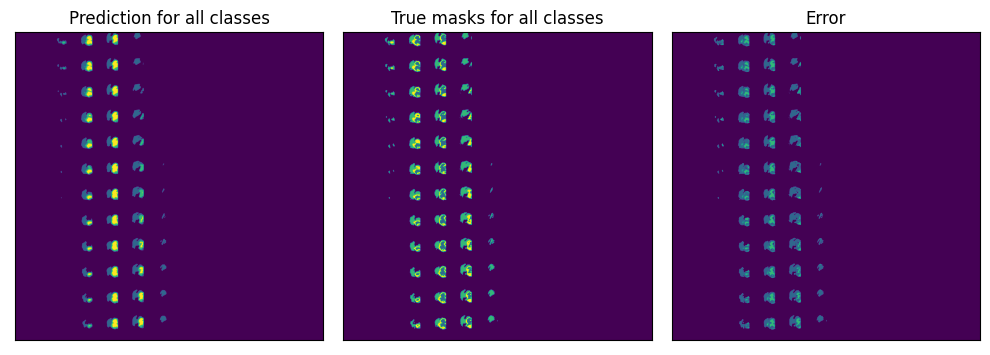

In [35]:
fig, ax = plt.subplots(1, 3, figsize = (10, 10))
total_prediction = np.squeeze(np.sum(predictions, axis=0))
ax[0].imshow(np.rot90(montage(total_prediction)))
ax[0].set_title(f'Prediction for all classes')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(np.rot90(montage(true_masks[val_idx].numpy())))
ax[1].set_title(f'True masks for all classes')
ax[1].set_xticks([])
ax[1].set_yticks([])

error = np.abs(total_prediction - true_masks[val_idx].numpy())
ax[2].imshow(np.rot90(montage(error)))
ax[2].set_title(f'Error')
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.tight_layout()

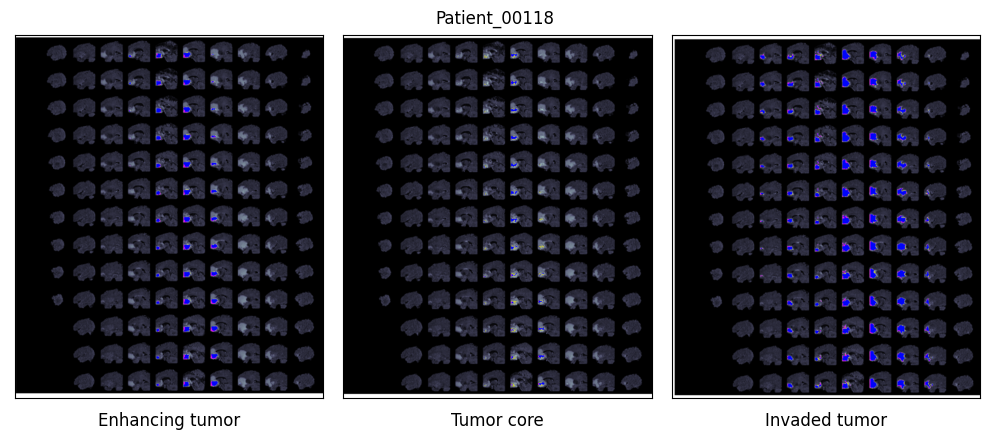

In [68]:
from pathlib import Path
import matplotlib.pyplot as plt
patient_1_dir = Path(str('/Users/christianvalentinkjaer/Documents/DTU/E23/02456_Deep_Learning/poster_plot/Patient1'))
patient_2_dir = Path(str('/Users/christianvalentinkjaer/Documents/DTU/E23/02456_Deep_Learning/poster_plot/Patient2'))
ext1 = ['ET_1', 'TC_1', 'IT_1']
ext2 = ['ET_2', 'TC_2', 'IT_2']
names = ['Enhancing tumor', 'Tumor core', 'Invaded tumor']
#Make 2x3 subplot
fig, ax = plt.subplots(1,3, figsize = (10, 10))

for i in range(len(ext1)):
    img = Image.open(patient_2_dir / f'{ext2[i]}.png')
    ax[i].imshow(img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f'{names[i]}',y=-0.1)
plt.suptitle('Patient_00118',y=0.69)
plt.tight_layout()
plt.savefig('Patient_00118.png', dpi=300)

In [74]:
from pathlib import Path

val_path = Path(str('/Users/christianvalentinkjaer/Documents/DTU/E23/02456_Deep_Learning/val_scores'))

dice_ET = np.load(val_path / 'dice_ET.npy')
dice_TC = np.load(val_path / 'dice_TC.npy')
dice_IT = np.load(val_path / 'dice_IT.npy')

jac_ET = np.load(val_path / 'jac_ET.npy')
jac_TC = np.load(val_path / 'jac_TC.npy')
jac_IT = np.load(val_path / 'jac_IT.npy')

means_dice = [np.mean(dice_ET), np.mean(dice_TC), np.mean(dice_IT)]
std_dice = [np.std(dice_ET), np.std(dice_TC), np.std(dice_IT)]

means_jac = [np.mean(jac_ET), np.mean(jac_TC), np.mean(jac_IT)]
std_jac = [np.std(jac_ET), np.std(jac_TC), np.std(jac_IT)]


In [78]:
print('Enchancing tumor, Tumor core, Invaded tumor')
print(f'means_dice {[round(val, 3) for val in means_dice]}')
print(f'std_dice {[round(val, 3) for val in std_dice]}')
print(f'means_jac {[round(val, 3) for val in means_jac]}')
print(f'std_jac {[round(val, 3) for val in std_jac]}')

Enchancing tumor, Tumor core, Invaded tumor
means_dice [0.995, 0.997, 0.989]
std_dice [0.005, 0.003, 0.007]
means_jac [0.884, 0.81, 0.886]
std_jac [0.065, 0.111, 0.068]


In [82]:
from pathlib import Path

val_path = Path(str('/Users/christianvalentinkjaer/Documents/DTU/E23/02456_Deep_Learning/total_scores'))

total_jac = np.load(val_path / 'total_jaccard_scores.npy')
total_dice = np.load(val_path / 'total_dice_scores.npy')

means_dice = np.mean(total_dice)
std_dice = np.std(total_dice)

means_jac = np.mean(total_jac)
std_jac = np.std(total_jac)

print(f'means_dice {round(means_dice, 3)}')
print(f'std_dice {round(std_dice, 3)}')
print(f'means_jac {round(means_jac, 3)}')
print(f'std_jac {round(std_jac, 3)}')

means_dice 0.9480000138282776
std_dice 0.01899999938905239
means_jac 0.26899999380111694
std_jac 0.009999999776482582
